In [1]:
#credit card fault detection problem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
# importing dataset
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# a highly unbalanced datasets
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
neg,pos = np.bincount(df['Class'])
print("the positive labels arre ",pos,"and the negative labels are ",neg)

the positive labels arre  492 and the negative labels are  284315


In [5]:
df.drop(labels='Time',axis=1,inplace=True)

In [6]:
df['Amount'] = df['Amount'].apply((lambda x: np.log(x+0.01)))

In [7]:
import seaborn as sns

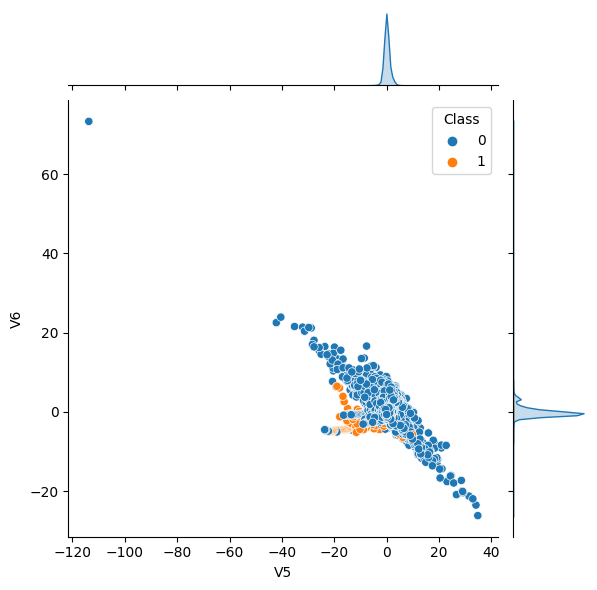

In [8]:
sns.jointplot(x='V5',y='V6',data= df,hue='Class')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [12]:
from sklearn.preprocessing import StandardScaler

In [189]:
sc = StandardScaler()

In [190]:
X_train_transform = sc.fit_transform(X_train)

In [15]:
from tensorflow import keras

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
def make_model(metrics=METRICS,output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.models.Sequential([
            keras.layers.Dense(10,activation='relu',input_shape=(X_train_transform.shape[1],)),
            keras.layers.Dropout(0.2),
                keras.layers.Dense(1,activation='sigmoid',bias_initializer=output_bias)
                    ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model 

In [18]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_prc',patience=5,mode='max',restore_best_weights=True)

In [19]:
model = make_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                300       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 100
BATCH_SIZE = 2048
model.predict(X_train_transform)
model.evaluate(X_train_transform,y_train,batch_size=BATCH_SIZE,verbose=0)

7121/7121 [==============================] - 12s 1ms/step


[0.5363261699676514,
 5.0,
 62876.0,
 164567.0,
 397.0,
 0.7222980260848999,
 7.951527368277311e-05,
 0.012437811121344566,
 0.09071973711252213,
 0.0009107158402912319]

In [22]:
print("loss at the None intialization is = 1.02")

loss at the None intialization is = 1.02


In [23]:
# these are results obatined from the model with intial intialization is and we can see that these are not great 

In [24]:
#lets try to intialize the  bias as pos/total = 0.00172
model = make_model(output_bias=0.00172)
model.predict(X_train_transform)
loss = model.evaluate(X_train_transform,y_train,batch_size=BATCH_SIZE,verbose=0)


7121/7121 [==============================] - 11s 2ms/step


In [25]:
print("with the intialization 0.00172 the loss is = ",loss[0])

with the intialization 0.00172 the loss is =  1.6787774562835693


In [26]:
#thus it can be seen that the intialization of bias has significantly changes the results
import os
import tempfile

In [27]:
# Save the intial weights

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')

In [28]:
model.save_weights(initial_weights)

In [188]:
X_test_transform = sc.transform(X_test)

C:\Users\nares\anaconda3\envs\ineurontf\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [30]:
# 1. Train the model for 20 epochs with careful and random intialization and compare the results
model.layers[-1].bias.assign([0.0])
zero_bias_model = model.fit(X_train_transform,y_train,    batch_size=BATCH_SIZE,
    epochs=5,verbose=0,validation_data=(X_test_transform,y_test))

In [31]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
   X_train_transform,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    validation_data=(X_test_transform, y_test), 
    verbose=0)

In [32]:
def plot_loss(history,label,n):
    plt.semilogy(history.epoch,history.history['loss'],label=label)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("Loss ")

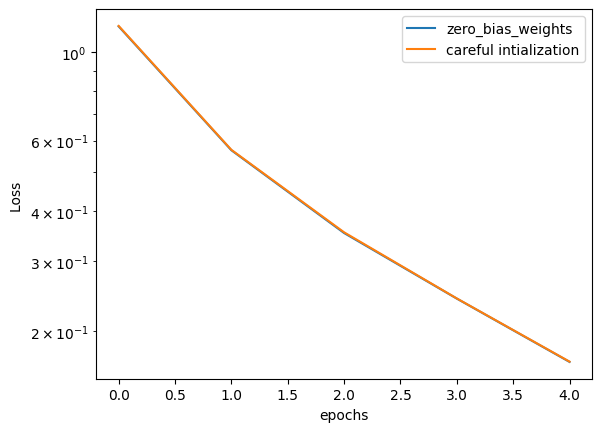

In [33]:
plot_loss(zero_bias_model,"zero_bias_weights",0)
plot_loss(careful_bias_history,"careful intialization",1)

In [34]:
# Thus it can be seen that in our case zero bias initialization give more advantage thus training the model with that 

In [35]:
model = make_model()
model.layers[-1].bias.assign([0.0])
base_line_model = model.fit(X_train_transform,y_train, batch_size=BATCH_SIZE,
epochs=EPOCHS,verbose=0,validation_data=(X_test_transform,y_test),callbacks=[early_stopping])

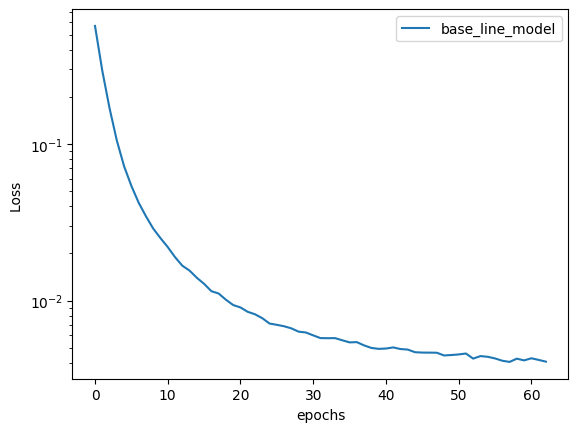

In [36]:
plot_loss(base_line_model,"base_line_model",1)

In [37]:
df = pd.DataFrame(data = base_line_model.history)

In [38]:
df.head()

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,0.569575,276.0,72191.0,212124.0,216.0,0.745768,0.003809,0.560976,0.685522,0.177583,0.354431,48.0,4553.0,52319.0,42.0,0.919332,0.010433,0.533333,0.695491,0.281716
1,0.294720,201.0,13689.0,213754.0,201.0,0.939038,0.014471,0.500000,0.701655,0.264782,0.181586,48.0,157.0,56715.0,42.0,0.996506,0.234146,0.533333,0.758702,0.386218
2,0.169592,174.0,2314.0,225129.0,228.0,0.988843,0.069936,0.432836,0.758730,0.265247,0.094560,44.0,9.0,56863.0,46.0,0.999034,0.830189,0.488889,0.802726,0.493526
3,0.105415,190.0,543.0,226900.0,212.0,0.996686,0.259209,0.472637,0.791358,0.371911,0.052531,51.0,10.0,56862.0,39.0,0.999140,0.836066,0.566667,0.835408,0.551700
4,0.072158,192.0,193.0,227250.0,210.0,0.998231,0.498701,0.477612,0.838604,0.407450,0.032233,51.0,10.0,56862.0,39.0,0.999140,0.836066,0.566667,0.856806,0.599336


In [39]:
def plot_metrics(history,label):
    plt.plot(history.epoch,history.history[label],label=label)
    plt.plot(history.epoch,history.history["val_"+label],label='val_'+label)
    plt.legend()
    plt.xlabel("epochs")

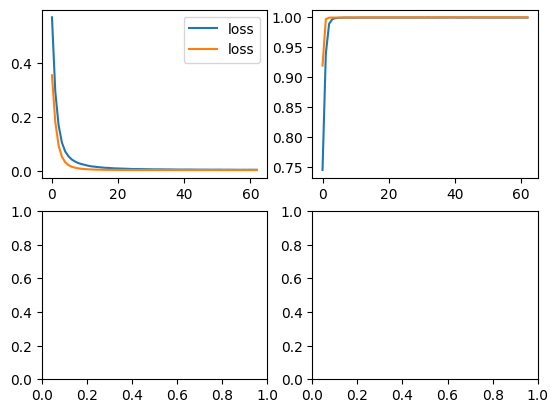

In [40]:
fig,axes = plt.subplots(2,2)
ax0,ax1,ax2,ax3 = axes.flat
ax0.plot(base_line_model.epoch,base_line_model.history['loss'],base_line_model.history['val_loss'],label='loss')
ax0.legend()
ax1.plot(base_line_model.epoch,base_line_model.history['accuracy'],base_line_model.history['val_accuracy'],label='loss')
ax0.legend()


In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
y_predict = model.predict(X_test_transform,batch_size=30)

1899/1899 [==============================] - 3s 2ms/step


In [61]:
y_prediction = np.where(y_predict>0.5,1,0)

In [44]:
cm = confusion_matrix(y_test,y_prediction)

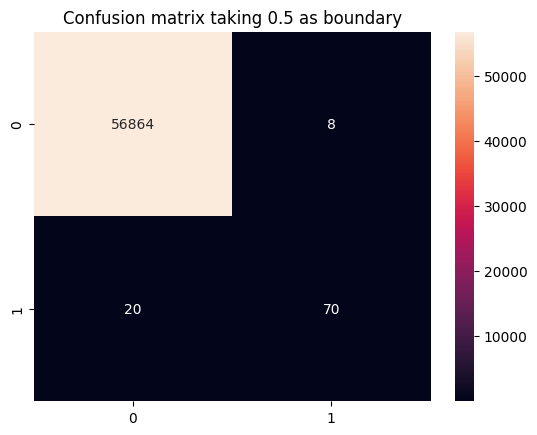

In [45]:
plt.title("Confusion matrix taking 0.5 as boundary")
sns.heatmap(cm,annot=True,fmt='d')
plt.show()

In [46]:
# It can be seen that there are some false positive i.e 13 these are those transcation which are flagged off by the system 
# but these were not fraud ones , false negatives shows that these were predicted as legitimate transcation infact which were not
# thus here we should consider reducing false negatives

In [47]:
#Now plotting ROC to determine the threshold
from sklearn.metrics import roc_curve

In [48]:
y_train_prediction = model.predict(X_train_transform)

7121/7121 [==============================] - 12s 2ms/step


In [49]:
fpr_tr,tpr_tr,thre_tr = roc_curve(y_train,y_train_prediction)

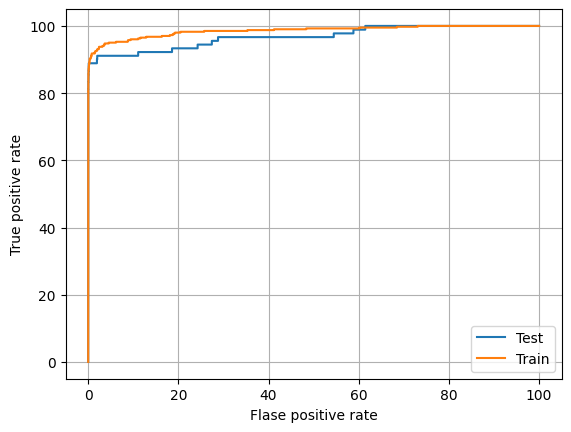

In [50]:
fpr,tpr,thre =roc_curve(y_test,y_predict)
plt.plot(100*fpr,100*tpr,label="Test")
plt.plot(100*fpr_tr,100*tpr_tr,label="Train")
plt.xlabel("Flase positive rate")
plt.ylabel("True positive rate")
plt.grid("both")
plt.legend()
plt.show()

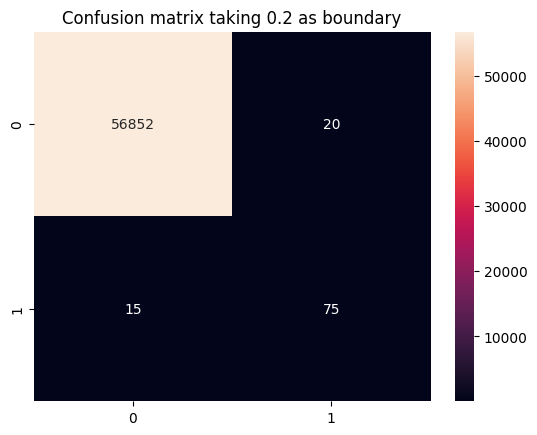

In [52]:
y_prediction = np.where(y_predict>=0.2,1,0)
cm = confusion_matrix(y_test,y_prediction)
plt.title("Confusion matrix taking 0.2 as boundary")
sns.heatmap(cm,annot=True,fmt='d')
plt.show()

In [53]:
from sklearn.metrics import precision_recall_curve

In [63]:
#Plotting AUPRC precision recall curve for various thresholds
def plot_prc(name,labels,predictions,**kwargs):
    pr,rec,thres = precision_recall_curve(labels,predictions)
    plt.plot(rec,pr,label=name,**kwargs)
    plt.legend()
    plt.grid("both")

In [64]:
y_train_predict = np.where(y_train_prediction>0.5,1,0)

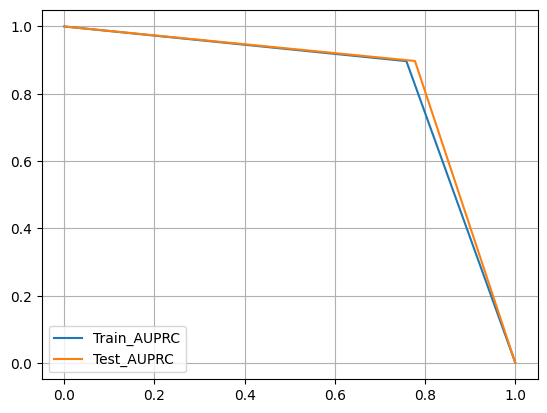

In [70]:
plot_prc("Train_AUPRC",y_train,y_train_predict)
plot_prc("Test_AUPRC",y_test,y_prediction)

In [71]:
#here we see that Fraud detection is important thus any positive signal doesnt get missed , thus we should lower false negative
# or we can say that we need to increase recall , also we see that if we lower the threshold to decrease false negative we may
# end up in classifying more fraud which are actually not fraud and customer needs to check the detail which may further 
# cause unhappiness thus precision should also be ensured


In [72]:
#As here we dont have more positive examples due to imbalance data we need
# to assign more weight for the few samples that we have during training , this will cause the model to pay more attention
# to examples that are underrepresented


In [73]:
weight_for_0 = 0.5*(pos+neg)*(1/neg)
weight_for_1 = 0.5*(pos+neg)*(1/pos)

In [74]:
class_weights ={0:weight_for_0,1:weight_for_1}

In [78]:
EPOCHS
BATCH_SIZE

2048

In [80]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(X_train_transform,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[early_stopping],class_weight=class_weights)

Epoch 1/100
112/112 [==============================] - 3s 13ms/step - loss: 0.7452 - tp: 457.0000 - fp: 159980.0000 - tn: 124335.0000 - fn: 35.0000 - accuracy: 0.4382 - precision: 0.0028 - recall: 0.9289 - auc: 0.8480 - prc: 0.0428
Epoch 2/100
112/112 [==============================] - 1s 12ms/step - loss: 0.4728 - tp: 389.0000 - fp: 112074.0000 - tn: 115369.0000 - fn: 13.0000 - accuracy: 0.5081 - precision: 0.0035 - recall: 0.9677 - auc: 0.9384 - prc: 0.1824
Epoch 3/100
112/112 [==============================] - 1s 12ms/step - loss: 0.3588 - tp: 380.0000 - fp: 70352.0000 - tn: 157091.0000 - fn: 22.0000 - accuracy: 0.6911 - precision: 0.0054 - recall: 0.9453 - auc: 0.9534 - prc: 0.3538
Epoch 4/100
112/112 [==============================] - 1s 12ms/step - loss: 0.3056 - tp: 375.0000 - fp: 38083.0000 - tn: 189360.0000 - fn: 27.0000 - accuracy: 0.8327 - precision: 0.0098 - recall: 0.9328 - auc: 0.9599 - prc: 0.5347
Epoch 5/100
112/112 [==============================] - 1s 10ms/step - loss

112/112 [==============================] - 1s 12ms/step - loss: 0.1639 - tp: 369.0000 - fp: 7166.0000 - tn: 220277.0000 - fn: 33.0000 - accuracy: 0.9684 - precision: 0.0490 - recall: 0.9179 - auc: 0.9825 - prc: 0.6249
Epoch 15/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1582 - tp: 369.0000 - fp: 7080.0000 - tn: 220363.0000 - fn: 33.0000 - accuracy: 0.9688 - precision: 0.0495 - recall: 0.9179 - auc: 0.9832 - prc: 0.6331
Epoch 16/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1531 - tp: 371.0000 - fp: 6989.0000 - tn: 220454.0000 - fn: 31.0000 - accuracy: 0.9692 - precision: 0.0504 - recall: 0.9229 - auc: 0.9847 - prc: 0.6439
Epoch 17/100
112/112 [==============================] - 1s 10ms/step - loss: 0.1586 - tp: 368.0000 - fp: 6906.0000 - tn: 220537.0000 - fn: 34.0000 - accuracy: 0.9695 - precision: 0.0506 - recall: 0.9154 - auc: 0.9821 - prc: 0.6492
Epoch 18/100
112/112 [==============================] - 1s 10ms/step - loss: 0.1444 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1298 - tp: 373.0000 - fp: 6642.0000 - tn: 220801.0000 - fn: 29.0000 - accuracy: 0.9707 - precision: 0.0532 - recall: 0.9279 - auc: 0.9893 - prc: 0.6160
Epoch 29/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1367 - tp: 372.0000 - fp: 6812.0000 - tn: 220631.0000 - fn: 30.0000 - accuracy: 0.9700 - precision: 0.0518 - recall: 0.9254 - auc: 0.9872 - prc: 0.6109
Epoch 30/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1288 - tp: 374.0000 - fp: 7359.0000 - tn: 220084.0000 - fn: 28.0000 - accuracy: 0.9676 - precision: 0.0484 - recall: 0.9303 - auc: 0.9891 - prc: 0.6082
Epoch 31/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1308 - tp: 376.0000 - fp: 6795.0000 - tn: 220648.0000 - fn: 26.0000 - accuracy: 0.9701 - precision: 0.0524 - recall: 0.9353 - auc: 0.9891 - prc: 0.6085
Epoch 32/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1277 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1224 - tp: 379.0000 - fp: 6195.0000 - tn: 221248.0000 - fn: 23.0000 - accuracy: 0.9727 - precision: 0.0577 - recall: 0.9428 - auc: 0.9892 - prc: 0.6249
Epoch 42/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1271 - tp: 378.0000 - fp: 6207.0000 - tn: 221236.0000 - fn: 24.0000 - accuracy: 0.9727 - precision: 0.0574 - recall: 0.9403 - auc: 0.9885 - prc: 0.5939
Epoch 43/100
112/112 [==============================] - 1s 12ms/step - loss: 0.1201 - tp: 376.0000 - fp: 5979.0000 - tn: 221464.0000 - fn: 26.0000 - accuracy: 0.9736 - precision: 0.0592 - recall: 0.9353 - auc: 0.9905 - prc: 0.5979
Epoch 44/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1158 - tp: 384.0000 - fp: 6331.0000 - tn: 221112.0000 - fn: 18.0000 - accuracy: 0.9721 - precision: 0.0572 - recall: 0.9552 - auc: 0.9912 - prc: 0.6082
Epoch 45/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1162 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1133 - tp: 381.0000 - fp: 6100.0000 - tn: 221343.0000 - fn: 21.0000 - accuracy: 0.9731 - precision: 0.0588 - recall: 0.9478 - auc: 0.9917 - prc: 0.6163
Epoch 56/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1127 - tp: 377.0000 - fp: 5767.0000 - tn: 221676.0000 - fn: 25.0000 - accuracy: 0.9746 - precision: 0.0614 - recall: 0.9378 - auc: 0.9922 - prc: 0.6301
Epoch 57/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1171 - tp: 379.0000 - fp: 6591.0000 - tn: 220852.0000 - fn: 23.0000 - accuracy: 0.9710 - precision: 0.0544 - recall: 0.9428 - auc: 0.9913 - prc: 0.6096
Epoch 58/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1183 - tp: 379.0000 - fp: 6424.0000 - tn: 221019.0000 - fn: 23.0000 - accuracy: 0.9717 - precision: 0.0557 - recall: 0.9428 - auc: 0.9911 - prc: 0.6224
Epoch 59/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1086 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1178 - tp: 375.0000 - fp: 6582.0000 - tn: 220861.0000 - fn: 27.0000 - accuracy: 0.9710 - precision: 0.0539 - recall: 0.9328 - auc: 0.9907 - prc: 0.6068
Epoch 69/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1116 - tp: 382.0000 - fp: 6295.0000 - tn: 221148.0000 - fn: 20.0000 - accuracy: 0.9723 - precision: 0.0572 - recall: 0.9502 - auc: 0.9917 - prc: 0.6133
Epoch 70/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1090 - tp: 378.0000 - fp: 6102.0000 - tn: 221341.0000 - fn: 24.0000 - accuracy: 0.9731 - precision: 0.0583 - recall: 0.9403 - auc: 0.9931 - prc: 0.6221
Epoch 71/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1134 - tp: 382.0000 - fp: 6345.0000 - tn: 221098.0000 - fn: 20.0000 - accuracy: 0.9721 - precision: 0.0568 - recall: 0.9502 - auc: 0.9911 - prc: 0.6322
Epoch 72/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1111 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1017 - tp: 384.0000 - fp: 5766.0000 - tn: 221677.0000 - fn: 18.0000 - accuracy: 0.9746 - precision: 0.0624 - recall: 0.9552 - auc: 0.9936 - prc: 0.6131
Epoch 83/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1026 - tp: 380.0000 - fp: 5706.0000 - tn: 221737.0000 - fn: 22.0000 - accuracy: 0.9749 - precision: 0.0624 - recall: 0.9453 - auc: 0.9938 - prc: 0.6214
Epoch 84/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1032 - tp: 385.0000 - fp: 6308.0000 - tn: 221135.0000 - fn: 17.0000 - accuracy: 0.9722 - precision: 0.0575 - recall: 0.9577 - auc: 0.9935 - prc: 0.6106
Epoch 85/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1021 - tp: 382.0000 - fp: 6158.0000 - tn: 221285.0000 - fn: 20.0000 - accuracy: 0.9729 - precision: 0.0584 - recall: 0.9502 - auc: 0.9942 - prc: 0.6040
Epoch 86/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1065 - tp:

112/112 [==============================] - 1s 11ms/step - loss: 0.1034 - tp: 383.0000 - fp: 5623.0000 - tn: 221820.0000 - fn: 19.0000 - accuracy: 0.9752 - precision: 0.0638 - recall: 0.9527 - auc: 0.9936 - prc: 0.6097
Epoch 96/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1043 - tp: 381.0000 - fp: 6082.0000 - tn: 221361.0000 - fn: 21.0000 - accuracy: 0.9732 - precision: 0.0590 - recall: 0.9478 - auc: 0.9931 - prc: 0.5947
Epoch 97/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1031 - tp: 380.0000 - fp: 5530.0000 - tn: 221913.0000 - fn: 22.0000 - accuracy: 0.9756 - precision: 0.0643 - recall: 0.9453 - auc: 0.9936 - prc: 0.6048
Epoch 98/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1036 - tp: 379.0000 - fp: 6368.0000 - tn: 221075.0000 - fn: 23.0000 - accuracy: 0.9720 - precision: 0.0562 - recall: 0.9428 - auc: 0.9936 - prc: 0.5905
Epoch 99/100
112/112 [==============================] - 1s 11ms/step - loss: 0.1019 - tp:

In [84]:
weighted_history = weighted_model.history.history

In [114]:
wei

AttributeError: 'Sequential' object has no attribute 'epochs'

In [107]:
plt.semilogy(weighted_model.epoch,weighted_history['loss'])

AttributeError: 'dict' object has no attribute 'epoch'

In [94]:
y_cw_predict = weighted_model.predict(X_test_transform,batch_size=40)

1425/1425 [==============================] - 2s 2ms/step


In [101]:
y_cw_predictions = np.where(y_cw_predict>0.5,1,0)

Text(50.722222222222214, 0.5, 'Actual label')

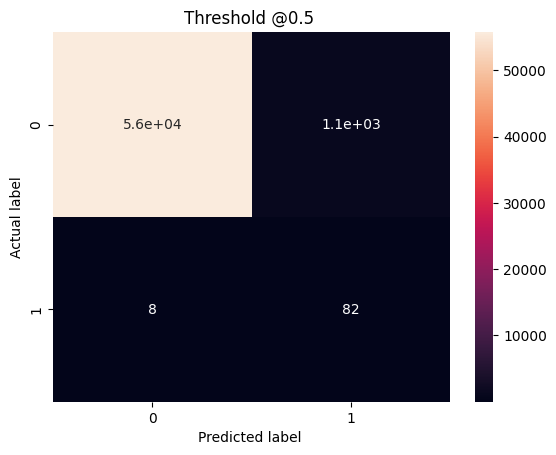

In [102]:
cm = confusion_matrix(y_test,y_cw_predictions)
sns.heatmap(cm,annot=True)
plt.title("Threshold @0.5 ")
plt.xlabel("Predicted label ")
plt.ylabel("Actual label")

In [103]:
# here we see that @0.5 , the number of false negative has decreased from 17 to 8 thus recall is more now ,
# but concern is there that false positive has increased slightly which may not be much difficult case


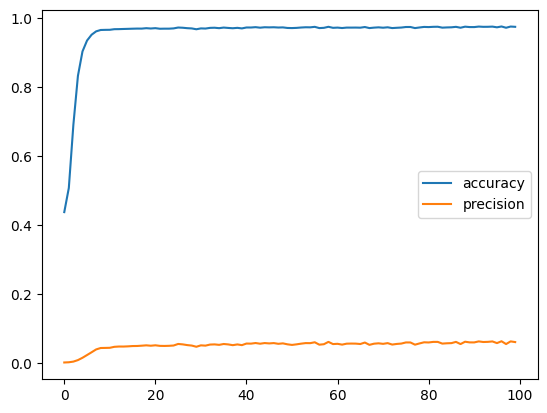

In [117]:
plt.plot(weighted_history['accuracy'],label='accuracy')
plt.plot(weighted_history['precision'],label='precision')
plt.legend()

In [118]:
# We see that tho accuracy is more this model has more efficacy to show fraudlent transcation

In [119]:
# Second Method is to Oversample the minor data while training


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,0.569575,276.0,72191.0,212124.0,216.0,0.745768,0.003809,0.560976,0.685522,0.177583,0.354431,48.0,4553.0,52319.0,42.0,0.919332,0.010433,0.533333,0.695491,0.281716
1,0.294720,201.0,13689.0,213754.0,201.0,0.939038,0.014471,0.500000,0.701655,0.264782,0.181586,48.0,157.0,56715.0,42.0,0.996506,0.234146,0.533333,0.758702,0.386218
2,0.169592,174.0,2314.0,225129.0,228.0,0.988843,0.069936,0.432836,0.758730,0.265247,0.094560,44.0,9.0,56863.0,46.0,0.999034,0.830189,0.488889,0.802726,0.493526
3,0.105415,190.0,543.0,226900.0,212.0,0.996686,0.259209,0.472637,0.791358,0.371911,0.052531,51.0,10.0,56862.0,39.0,0.999140,0.836066,0.566667,0.835408,0.551700
4,0.072158,192.0,193.0,227250.0,210.0,0.998231,0.498701,0.477612,0.838604,0.407450,0.032233,51.0,10.0,56862.0,39.0,0.999140,0.836066,0.566667,0.856806,0.599336


In [121]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [163]:
df.drop(labels='Time',axis=1,inplace=True)

In [164]:
pos_labels = df[df['Class']==0]['Class'].values
pos_index =  df[df['Class']==0].index

In [165]:
pos_features = np.array(df.iloc[pos_index,:-1])

In [166]:
pos_features.shape

(284315, 29)

In [167]:
neg_labels = df[df['Class']==1]['Class'].values
neg_index =  df[df['Class']==1].index


In [168]:
neg_features = np.array(df.iloc[neg_index,:-1])

In [169]:
ids = np.arange(len(pos_labels))

In [170]:
choices = np.random.choice(ids,len(neg_labels))

In [171]:
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

In [172]:
resample_features = np.concatenate([res_pos_features,neg_features],axis=0)
resample_labels = np.concatenate([res_pos_labels,neg_labels],axis=0)

In [173]:
order = np.arange(len(resample_labels))
np.random.shuffle(order)

In [174]:
resample_features = resample_features[order]
resample_labels = resample_labels[order]

In [194]:
X_train_res,X_test_res,y_train_re,y_test_re= train_test_split(resample_features,resample_labels,test_size=0.2)

In [195]:
X_train_transform = sc.fit_transform(X_train_res)

In [205]:
res_weight_model = make_model()
res_weight_model.load_weights(initial_weights)
weighted_history_res = res_weight_model.fit(X_train_transform,y_train_re,epochs=EPOCHS,batch_size=10,callbacks=[early_stopping],class_weight=class_weights)

Epoch 1/100
79/79 [==============================] - 3s 12ms/step - loss: 41.8864 - tp: 775.0000 - fp: 664.0000 - tn: 108.0000 - fn: 27.0000 - accuracy: 0.5610 - precision: 0.5386 - recall: 0.9663 - auc: 0.7337 - prc: 0.7701
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 20.0214 - tp: 395.0000 - fp: 341.0000 - tn: 45.0000 - fn: 6.0000 - accuracy: 0.5591 - precision: 0.5367 - recall: 0.9850 - auc: 0.8139 - prc: 0.8461
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 14.0542 - tp: 398.0000 - fp: 367.0000 - tn: 19.0000 - fn: 3.0000 - accuracy: 0.5299 - precision: 0.5203 - recall: 0.9925 - auc: 0.8087 - prc: 0.8452
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 10.4892 - tp: 401.0000 - fp: 376.0000 - tn: 10.0000 - fn: 0.0000e+00 - accuracy: 0.5222 - precision: 0.5161 - recall: 1.0000 - auc: 0.8003 - prc: 0.8373
Epoch 5/100
79/79 [==============================] - 1s 11ms/step - loss: 8.1228 - tp: 400.0000 - fp: 

Epoch 15/100
79/79 [==============================] - 1s 14ms/step - loss: 2.4438 - tp: 401.0000 - fp: 385.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.5108 - precision: 0.5102 - recall: 1.0000 - auc: 0.7818 - prc: 0.7370
Epoch 16/100
79/79 [==============================] - 1s 11ms/step - loss: 2.2772 - tp: 401.0000 - fp: 386.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5095 - precision: 0.5095 - recall: 1.0000 - auc: 0.7909 - prc: 0.7510
Epoch 17/100
79/79 [==============================] - 1s 10ms/step - loss: 2.4087 - tp: 401.0000 - fp: 383.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5133 - precision: 0.5115 - recall: 1.0000 - auc: 0.7864 - prc: 0.7398
Epoch 18/100
79/79 [==============================] - 1s 14ms/step - loss: 2.3663 - tp: 401.0000 - fp: 386.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5095 - precision: 0.5095 - recall: 1.0000 - auc: 0.7648 - prc: 0.7175
Epoch 19/100
79/79 [==============================] - 1s 14ms/step - loss: 1.9925 - tp: 

79/79 [==============================] - 1s 12ms/step - loss: 1.9079 - tp: 401.0000 - fp: 386.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5095 - precision: 0.5095 - recall: 1.0000 - auc: 0.8138 - prc: 0.7617
Epoch 29/100
79/79 [==============================] - 1s 10ms/step - loss: 1.8040 - tp: 401.0000 - fp: 386.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5095 - precision: 0.5095 - recall: 1.0000 - auc: 0.8122 - prc: 0.7585
Epoch 30/100
79/79 [==============================] - 1s 10ms/step - loss: 1.7096 - tp: 401.0000 - fp: 383.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5133 - precision: 0.5115 - recall: 1.0000 - auc: 0.8159 - prc: 0.7576
Epoch 31/100
79/79 [==============================] - 1s 10ms/step - loss: 1.8993 - tp: 401.0000 - fp: 386.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5095 - precision: 0.5095 - recall: 1.0000 - auc: 0.8139 - prc: 0.7557
Epoch 32/100
79/79 [==============================] - 1s 11ms/step - loss: 1.7651 - tp: 401.0000 

79/79 [==============================] - 1s 10ms/step - loss: 1.4196 - tp: 401.0000 - fp: 384.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.5121 - precision: 0.5108 - recall: 1.0000 - auc: 0.8684 - prc: 0.8161
Epoch 43/100
79/79 [==============================] - 1s 10ms/step - loss: 1.3459 - tp: 401.0000 - fp: 385.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.5108 - precision: 0.5102 - recall: 1.0000 - auc: 0.8727 - prc: 0.8164
Epoch 44/100
79/79 [==============================] - 1s 10ms/step - loss: 1.4413 - tp: 401.0000 - fp: 385.0000 - tn: 1.0000 - fn: 0.0000e+00 - accuracy: 0.5108 - precision: 0.5102 - recall: 1.0000 - auc: 0.8693 - prc: 0.8124
Epoch 45/100
79/79 [==============================] - 1s 11ms/step - loss: 1.3522 - tp: 401.0000 - fp: 383.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5133 - precision: 0.5115 - recall: 1.0000 - auc: 0.8784 - prc: 0.8272
Epoch 46/100
79/79 [==============================] - 1s 11ms/step - loss: 1.3175 - tp: 401.0000 - fp: 382.00

Epoch 56/100
79/79 [==============================] - 1s 10ms/step - loss: 1.2986 - tp: 401.0000 - fp: 380.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.5172 - precision: 0.5134 - recall: 1.0000 - auc: 0.9010 - prc: 0.8567
Epoch 57/100
79/79 [==============================] - 1s 10ms/step - loss: 1.2660 - tp: 401.0000 - fp: 379.0000 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 0.5184 - precision: 0.5141 - recall: 1.0000 - auc: 0.9142 - prc: 0.8757
Epoch 58/100
79/79 [==============================] - 1s 10ms/step - loss: 1.2666 - tp: 401.0000 - fp: 381.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.5159 - precision: 0.5128 - recall: 1.0000 - auc: 0.9144 - prc: 0.8762
Epoch 59/100
79/79 [==============================] - 1s 10ms/step - loss: 1.2288 - tp: 401.0000 - fp: 383.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5133 - precision: 0.5115 - recall: 1.0000 - auc: 0.9145 - prc: 0.8718
Epoch 60/100
79/79 [==============================] - 1s 11ms/step - loss: 1.3218 - tp: 401.0000

Epoch 70/100
79/79 [==============================] - 1s 12ms/step - loss: 1.1938 - tp: 401.0000 - fp: 382.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.5146 - precision: 0.5121 - recall: 1.0000 - auc: 0.9016 - prc: 0.8525
Epoch 71/100
79/79 [==============================] - 1s 13ms/step - loss: 1.3595 - tp: 401.0000 - fp: 381.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.5159 - precision: 0.5128 - recall: 1.0000 - auc: 0.9006 - prc: 0.8515
Epoch 72/100
79/79 [==============================] - 1s 11ms/step - loss: 1.2737 - tp: 401.0000 - fp: 380.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.5172 - precision: 0.5134 - recall: 1.0000 - auc: 0.8990 - prc: 0.8481
Epoch 73/100
79/79 [==============================] - 1s 13ms/step - loss: 1.3227 - tp: 401.0000 - fp: 379.0000 - tn: 7.0000 - fn: 0.0000e+00 - accuracy: 0.5184 - precision: 0.5141 - recall: 1.0000 - auc: 0.9193 - prc: 0.8810
Epoch 74/100
79/79 [==============================] - 1s 12ms/step - loss: 1.2957 - tp: 401.0000

Epoch 84/100
79/79 [==============================] - 1s 11ms/step - loss: 1.1013 - tp: 401.0000 - fp: 380.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.5172 - precision: 0.5134 - recall: 1.0000 - auc: 0.9252 - prc: 0.8839
Epoch 85/100
79/79 [==============================] - 1s 11ms/step - loss: 1.0715 - tp: 401.0000 - fp: 380.0000 - tn: 6.0000 - fn: 0.0000e+00 - accuracy: 0.5172 - precision: 0.5134 - recall: 1.0000 - auc: 0.9340 - prc: 0.8984
Epoch 86/100
79/79 [==============================] - 1s 11ms/step - loss: 1.1550 - tp: 401.0000 - fp: 376.0000 - tn: 10.0000 - fn: 0.0000e+00 - accuracy: 0.5222 - precision: 0.5161 - recall: 1.0000 - auc: 0.9133 - prc: 0.8692
Epoch 87/100
79/79 [==============================] - 1s 11ms/step - loss: 1.2700 - tp: 401.0000 - fp: 376.0000 - tn: 10.0000 - fn: 0.0000e+00 - accuracy: 0.5222 - precision: 0.5161 - recall: 1.0000 - auc: 0.9224 - prc: 0.8847
Epoch 88/100
79/79 [==============================] - 1s 11ms/step - loss: 1.1175 - tp: 401.00

Epoch 98/100
79/79 [==============================] - 1s 14ms/step - loss: 1.0041 - tp: 401.0000 - fp: 370.0000 - tn: 16.0000 - fn: 0.0000e+00 - accuracy: 0.5299 - precision: 0.5201 - recall: 1.0000 - auc: 0.9323 - prc: 0.8929
Epoch 99/100
79/79 [==============================] - 1s 14ms/step - loss: 0.9232 - tp: 401.0000 - fp: 367.0000 - tn: 19.0000 - fn: 0.0000e+00 - accuracy: 0.5337 - precision: 0.5221 - recall: 1.0000 - auc: 0.9365 - prc: 0.8978
Epoch 100/100
79/79 [==============================] - 1s 14ms/step - loss: 0.9728 - tp: 401.0000 - fp: 366.0000 - tn: 20.0000 - fn: 0.0000e+00 - accuracy: 0.5349 - precision: 0.5228 - recall: 1.0000 - auc: 0.9326 - prc: 0.8918


In [191]:
#old X_test for validation and using old ttranformed 
X_test_transform_re = sc.transform(X_test)

5697/5697 [==============================] - 9s 2ms/step


Text(50.722222222222214, 0.5, 'Actual label')

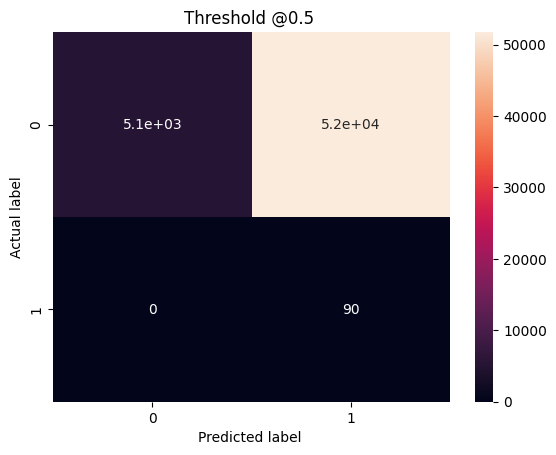

In [206]:
y_cw_res_predict = res_weight_model.predict(X_test_transform,batch_size=10)
y_cw__res_predictions = np.where(y_cw_res_predict>0.6,1,0)
cm = confusion_matrix(y_test,y_cw__res_predictions)
sns.heatmap(cm,annot=True)
plt.title("Threshold @0.5 ")
plt.xlabel("Predicted label ")
plt.ylabel("Actual label")

In [208]:
# here we see that the false negative has decreased ,but precision has also decreased 
# we need to change the threshold levels to come to a conclusion 
# from the above steps we see that , class weights approach gives better solutin than oversampling one in this case